# Evaluate Models
* In this notebooks we'll implement the inference and post inference part of the pipeline. 
* Along with that we'll also try and implement functions to validate the predictions visually. 

## Imports

In [47]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib.patches as patches



## validate tensorflow 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Constants

In [48]:
data_dir = Path("..","data")
models_dir = Path("..","models")

## Import Scripts

In [49]:
import os
import sys
# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import graph_compatible_data_generator,object_detection_model
from src import training_utils as tu

## logic to auto reload scripts without restarting the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test Data Pipeline

In [50]:
_, (x_test, y_test) = mnist.load_data()

X_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
# X_tensor = tf.reshape(X_tensor, shape=(-1, 28, 28, 1))
y_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

batch_size = 32
raw_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))

# create a generator for 2 digits
data_gen_2_digits = graph_compatible_data_generator.create_data_generator(2)
data_gen_3_digits = graph_compatible_data_generator.create_data_generator(3)
data_gen_4_digits = graph_compatible_data_generator.create_data_generator(4)
data_gen_5_digits = graph_compatible_data_generator.create_data_generator(5)

In [51]:
processed_test_dataset_2 = raw_dataset.map(
    data_gen_2_digits).map(lambda canvas,prediction: canvas).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

## Model Inference

### Load Model

In [52]:
model_name = "experiment_0_digits_2_20_0.33.keras"

model = tf.keras.models.load_model(Path(models_dir, model_name), custom_objects={
                                   "calculate_model_loss": tu.calculate_model_loss, "objectness_metrics": tu.objectness_metrics, "bounding_box_metrics": tu.bounding_box_metrics, "classification_metrics": tu.classification_metrics, "ObjectDetectionModel": object_detection_model.ObjectDetectionModel})
model.summary()

Model: "object_detection_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_5 (Functional)       │ (32, 6, 6, 45)         │        21,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,537 (256.01 KB)

 Trainable params: 21,845 (85.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,692 (170.68 KB)

### Prediction

In [53]:
processed_test_dataset_2 = raw_dataset.map(
    data_gen_2_digits).map(lambda canvas,prediction: canvas).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

prediction = model.predict(processed_test_dataset_2)



313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step


In [54]:
prediction.shape

(10000, 6, 6, 45)

In [55]:
## inspecting single prediction
single_pred = prediction[:1,...]
single_pred = tf.reshape(single_pred,shape=(-1,6,6,3, 15))
tf.sigmoid(single_pred[0,0,0,0])


<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0.00198382, 0.578911  , 0.24633276, 0.25505933, 0.20033774,
       0.37080115, 0.93498844, 0.3110254 , 0.55759573, 0.8927759 ,
       0.94222105, 0.5357569 , 0.8474629 , 0.48591155, 0.8047595 ],
      dtype=float32)>

## Post Processing
* In this step, we are going to post process the predictions to select the best anchor boxes from all the predictions
* To do this we'll,
    * Reshape it to easily access the `15` features that the model predicts,
    * Apply `tf.sigmoid` to the objectness score of the boxes and discard any boxes that are below the threshold.
    * Decode the coordinates returned by remaining boxes and apply Non-Max Suppresion (NMS) algorithm on it. 
* 

In [56]:
def reshape_prediction(prediction_object):
    prediction_shape = tf.shape(prediction_object)
    batch_size = prediction_shape[0]
    grid_width = prediction_shape[1]
    grid_height = prediction_shape[2]
    reshaped_prediction = tf.reshape(prediction_object, shape=(batch_size,grid_width,grid_height,-1,15))
    return reshaped_prediction

### Map Sigmoid Function - Confidence Scores


In [57]:
def map_confidence_score(prediction_object):
    ## objectness is the first flag in last axis
    confidence_score = tf.sigmoid(prediction_object[...,0])    
    return confidence_score


### Post Process Predictions

In [89]:


@tf.function
def post_process(predictions, confidence_score_threshold=0.5, iou_threshold=0.5, max_boxes=5):

    @tf.function
    def _process_single_prediction_image(prediction_image):
        # tf.print("prediction_image shape : ", tf.shape(prediction_image))
        image_shape = tf.shape(prediction_image)
        grid_width = tf.cast(image_shape[0], dtype=tf.float32)
        grid_height = tf.cast(image_shape[1], dtype=tf.float32)

        # step 0: normalize image
        normalized_image = tf.sigmoid(prediction_image[..., :5])
        # print("normalized image shape : ", tf.shape(normalized_image))
        # step 1: calculate confidence score
        confidence_scores = normalized_image[..., 0]
        # tf.print("confidence_scores shape : ", tf.shape(confidence_scores))

        # step 2: create boolean mask based on confidence score
        confidence_score_mask = confidence_scores[...,
                                                  :] > confidence_score_threshold
        # tf.print("confidence_score_mask ", tf.shape(confidence_score_mask))

        # create coordinate grid to decode the grid coordinates
        gridx_coordinate_range = tf.range(grid_width, dtype=tf.float32)
        gridy_coordinate_range = tf.range(grid_height, dtype=tf.float32)

        grid_y, grid_x = tf.meshgrid(
            gridy_coordinate_range, gridx_coordinate_range, indexing="ij")
        image_grid = tf.stack(values=[grid_y, grid_x], axis=-1)
        image_grid = image_grid[:, :, tf.newaxis, :]

        # decode the coordinates
        # Get the offsets and apply sigmoid
        x_offset = normalized_image[..., 1]
        y_offset = normalized_image[..., 2]

        # Get the grid indices (notice the swapped 0 and 1!)
        grid_x_index = image_grid[..., 1]
        grid_y_index = image_grid[..., 0]

        # 3. Apply the correct formula
        decoded_x_norm = (grid_x_index + x_offset) / grid_width
        decoded_y_norm = (grid_y_index + y_offset) / grid_height

        width = normalized_image[..., 3]
        height = normalized_image[..., 4]

        decoded_box = tf.stack(
            [decoded_x_norm, decoded_y_norm, width, height], axis=-1)

        # decode class
        class_scores = tf.nn.softmax(prediction_image[..., 5:], axis=-1)

        # decoded prediction
        confidence_scores = confidence_scores[:, :, :, tf.newaxis]
        decoded_prediction = tf.concat(
            [confidence_scores, decoded_box, class_scores], axis=-1)

        # # step 3: filter boxes based on the mask
        filtered_boxes = tf.boolean_mask(
            decoded_prediction, confidence_score_mask)
        # tf.print("filtered_boxes : ", tf.shape(filtered_boxes))

        # step 4: filter scores based on the mask
        filtered_scores = filtered_boxes[:, 0]
        # tf.print("filtered_scores : ", tf.shape(filtered_scores))

        # step 5: read and decode the values for NMS algorithm
        # prediction object flag, x_center, y_center, width, height, one hot encoded class values (0 to 9)
        x_center = filtered_boxes[..., 1] * 100
        y_center = filtered_boxes[..., 2] * 100
        width = filtered_boxes[..., 3] * 100
        height = filtered_boxes[..., 4] * 100

        # calculate min and max values
        x_min = tf.floor(x_center - (width / 2))
        x_max = tf.floor(x_center + (width / 2))
        y_min = tf.floor(y_center - (height / 2))
        y_max = tf.floor(y_center + (height / 2))

        boxes = tf.stack([y_min, x_min, y_max, x_max], axis=1)
        # tf.print("boxes shape : ", tf.shape(boxes))

        # step 5: perform NMLS
        nms_indices = tf.image.non_max_suppression(
            boxes=boxes, scores=filtered_scores, max_output_size=max_boxes, iou_threshold=iou_threshold)
        # tf.print("nms_indices : ", nms_indices)

        # step 6: Final boxes
        final_boxes = tf.gather(filtered_boxes, nms_indices)
        # tf.print("final_boxes.shape : ", tf.shape(final_boxes))

        return final_boxes

    # step 1: reshape predictions
    reshaped_prediction = reshape_prediction(predictions)
    # tf.print("reshaped_prediction shape : ", tf.shape(reshaped_prediction))

    # step 2: loop through the predictions and apply NMS to each prediction
    spec_final_data = tf.RaggedTensorSpec(
        shape=(None, 15), dtype=tf.float32, ragged_rank=0)

    final_predictions = tf.map_fn(
        _process_single_prediction_image, reshaped_prediction, parallel_iterations=20, fn_output_signature=spec_final_data)

    return final_predictions

# top_10_predictions = prediction[:10,...]
# output = post_process(predictions=top_10_predictions)
# tf.print("output shape : ", tf.shape(output))

## Visualize Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Class : 3, Probability : 72.8265609741211, color : r
x_min, y_min : (np.float32(-6.0), np.float32(62.0))
Class : 0, Probability : 99.83747100830078, color : b
x_min, y_min : (np.float32(28.0), np.float32(-7.0))


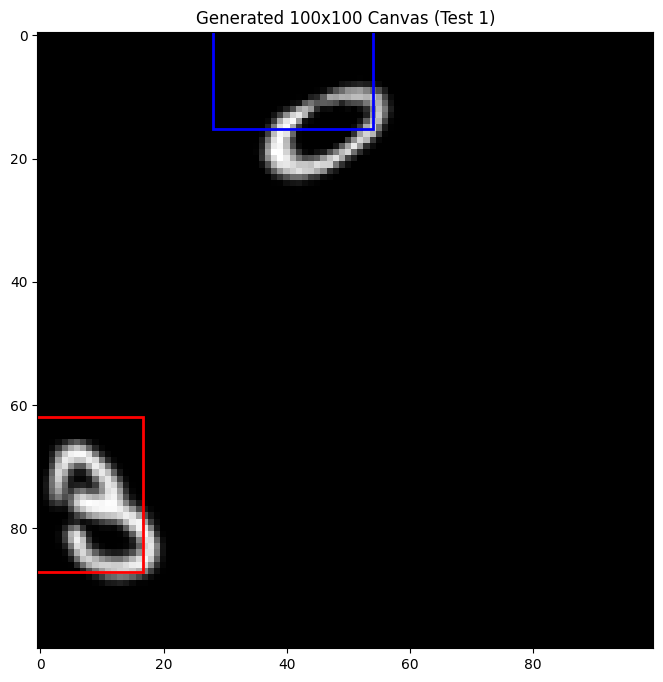

Class : 4, Probability : 99.99266052246094, color : r
x_min, y_min : (np.float32(68.0), np.float32(64.0))
Class : 9, Probability : 99.03166961669922, color : b
x_min, y_min : (np.float32(11.0), np.float32(-4.0))


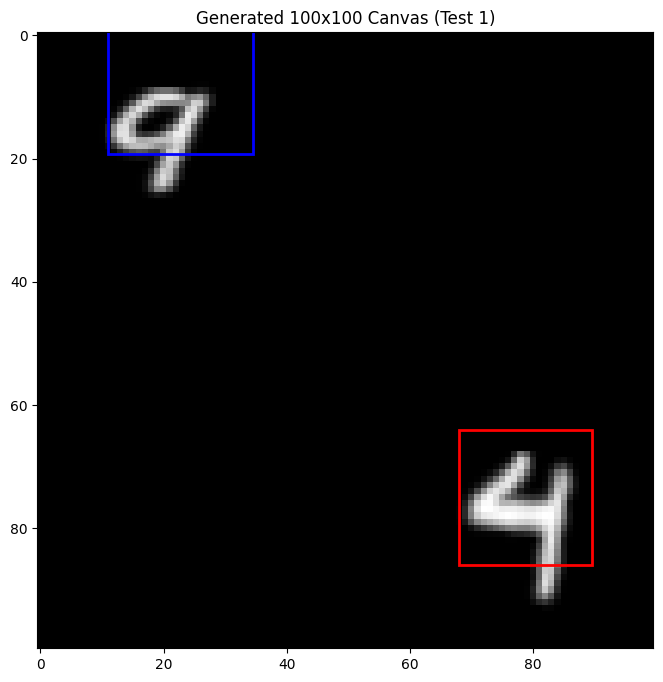

Class : 3, Probability : 72.8265609741211, color : r
x_min, y_min : (np.float32(-6.0), np.float32(62.0))
Class : 0, Probability : 99.83747100830078, color : b
x_min, y_min : (np.float32(28.0), np.float32(-7.0))


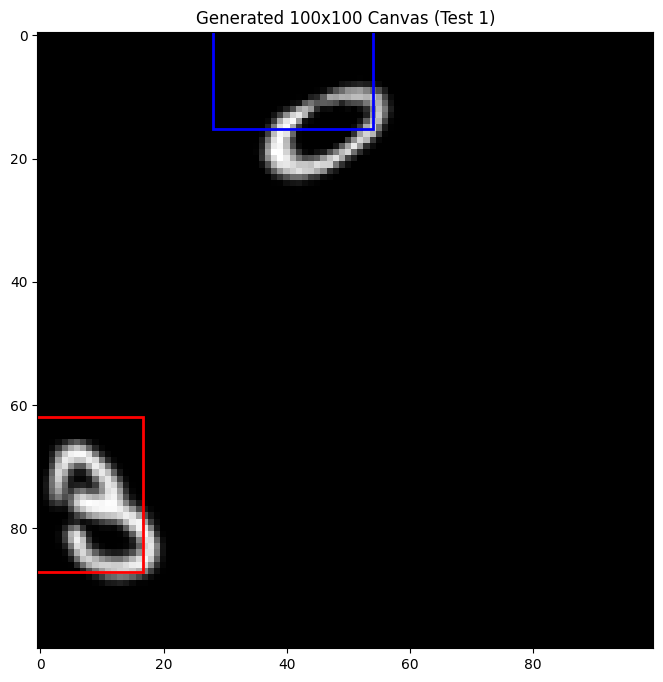

Class : 3, Probability : 72.8265609741211, color : r
x_min, y_min : (np.float32(-6.0), np.float32(62.0))
Class : 0, Probability : 99.83747100830078, color : b
x_min, y_min : (np.float32(28.0), np.float32(-7.0))


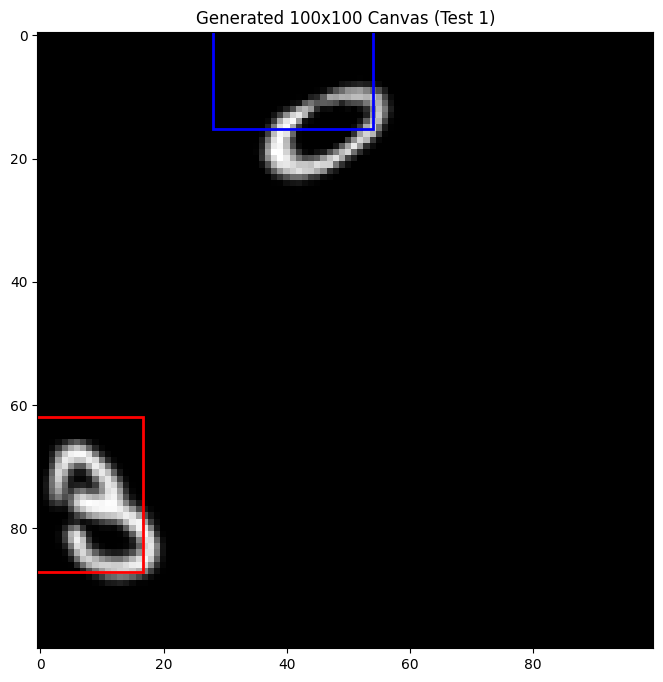

Class : 4, Probability : 99.9690170288086, color : r
x_min, y_min : (np.float32(12.0), np.float32(76.0))
Class : 4, Probability : 99.91992950439453, color : b
x_min, y_min : (np.float32(29.0), np.float32(78.0))


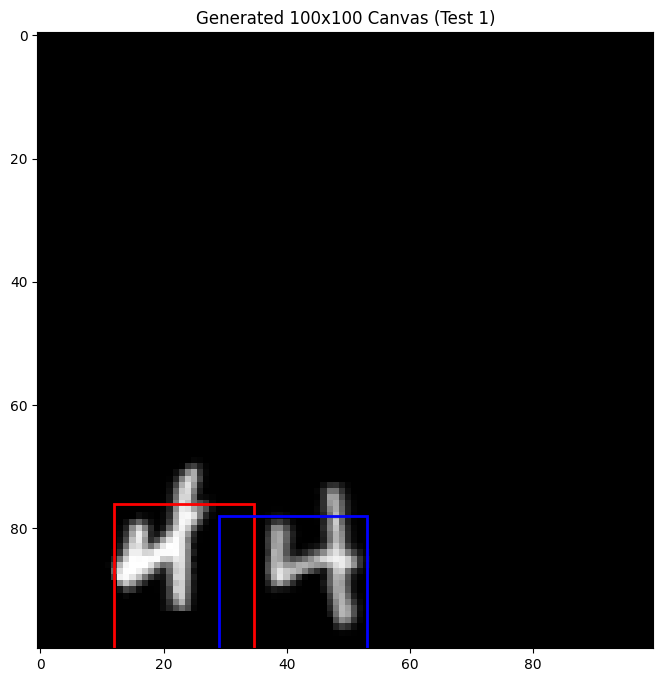

In [95]:
def visualize_generated_data(canvas, predictions):
    # batched_canvases,predictions = batch
    # print(f"batched_canvases shape: {canvas.shape}")
    # print(f"predictions shape ", tf.shape(predictions))
    # Get the very first canvas from the batch (shape 100x100)
    # We use .numpy() to convert it from a EagerTensor to a NumPy array for plotting
    canvas_shape = canvas.shape
    batch_size = canvas_shape[0]

    # select random int from 0 to batch size
    for counter in range(5):
        random_int = np.random.randint(0, batch_size)

        canvas_to_show = canvas[random_int].numpy()
        prediction = predictions[random_int]

        # print(f"Canvas shape: {canvas_to_show.shape}")
        # print(f"Single Prediction shape: {prediction.shape}")
        prediction_boxes = prediction.shape[0]

        # # Plot it
        # # --- Create a figure and axis ---
        fig, ax = plt.subplots(1, figsize=(8, 8))

        colors = ['r', 'b', 'g', 'y', 'c']

        # get the 2 predictions
        for i in range(prediction_boxes):
            bbox = (prediction[i]).numpy() * 100

            # flag, x_center, y_center, width, height,
            flag = bbox[0]
            x_center = bbox[1]
            y_center = bbox[2]
            width = bbox[3]
            height = bbox[4]
            pred_class = np.argmax(bbox[5:])
            pred_probability = bbox[5+pred_class]

            print(
                f"Class : {pred_class}, Probability : {pred_probability}, color : {colors[i]}")

            x_min = np.floor(x_center - (width / 2))
            y_min = np.floor(y_center - (height / 2))
            print(f"x_min, y_min : {x_min,y_min}")
            # print("flag, x_center, y_center, width, height",flag, x_min, y_min, width, height,)
            rect = patches.Rectangle(
                (x_min, y_min),
                width,
                height,
                linewidth=2,
                edgecolor=colors[i],
                facecolor='none'
            )

            ax.add_patch(rect)
        # Display the image
        ax.imshow(canvas_to_show, cmap='gray')

        plt.title("Generated 100x100 Canvas (Test 1)")
        plt.show()


# Get one batch
# Your dataset is batched, so .take(1) gets one full batch
for canvas in processed_test_dataset_2.take(1):
    # visualize_generated_data(batch=batch)
    # tf.print("canvas.shape ", tf.shape(canvas))
    predictions = model.predict(canvas)
    # tf.print("predictions.shape ", tf.shape(predictions))
    post_procesed_data = post_process(
        predictions=predictions, confidence_score_threshold=0.95, iou_threshold=0.2, max_boxes=3)
    # tf.print("post_procesed_data.shape ", tf.shape(post_procesed_data))
    visualize_generated_data(canvas, post_procesed_data)